In [5]:
# Imports
import pandas as pd
from IPython.display import display
import os
import itertools
import re
import numpy as np
import matplotlib.pyplot as plt 
import pickle 
import string
from collections import Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
import warnings
from sklearn.decomposition import NMF, LatentDirichletAllocation
import nltk
from nltk.tokenize import RegexpTokenizer
warnings.simplefilter("ignore")

In [6]:
def read_data(nsf_data_dir, pfile=False, wrt=False):
    if pfile == True:
        data = pickle.load( open( "data_1995_2003.p", "rb" ) )
        return data
    d = {}

    for root, dirs, files in os.walk(nsf_data_dir):
        print(root)
        for f in files:
            if 'txt' in f:
                d[f] = []
                fle = open(os.path.join(root, f), "r")
                content = ' '.join([ii.strip() for ii in fle.readlines()])
                d[f].append(re.search(r'NSF Org(.*?)Latest', content).group(1).strip(': '))
                d[f].append(content.split('Abstract')[1].strip(':  '))
                fle.close()

    
    data = pd.DataFrame.from_dict(d, orient='index')
    data.columns = ['Tag','Text']
    data['Text'] = data['Text'].str.replace('\n',' ').str.lower()
    data['Text'] = data['Text'].str.replace('\t',' ')
    data['Text'] = data['Text'].str.replace('_',' ')
    data['Text'] = data['Text'].str.replace('[^\w\s]',' ') # Removing punctuations
    data['Text'] = data['Text'].apply(lambda x: x.translate(str.maketrans(' ',' ',string.digits))) # Removing numbers
    if wrt:
        pickle.dump( data, open( "data_1995_2003.p", "wb" ) )
    
    return data

In [7]:
data = read_data('NSF',pfile=True)

# Have a look at how data is organized
display(data.head())

# Get a summary of data
display(data.describe())

,Tag,Text
a9500003.txt,OIG,not available
a9500006.txt,DMI,wang this award for a grant opportunity fo...
a9500007.txt,ECS,hagmann a pc and data acquisition board wil...
a9500009.txt,DMI,kim automated design methodology research ...
a9500010.txt,DMS,goncharov professor goncharov will work ...


,Tag,Text
count,82399,82399
unique,61,70777
top,DMS,
freq,6219,3022


In [8]:
# Search duplicates and keep only one from each
for text,count in Counter(data['Text']).items():
    if count>1:
        data.drop(list(data.index[data['Text']==text])[1::],axis=0,inplace=True)

# Get a summary of data again
display(data.describe())

,Tag,Text
count,70777,70777
unique,57,70777
top,DMS,abstract dendy e sloan colorado school of m...
freq,4889,1


In [9]:
# Search short (probably not informative) abstracts
c = Counter(data['Text'])
for text, count in c.items():
    if len(text) < 150: # try with 1000 as well and see how it affects
        data.drop(data.index[data['Text']==text],axis=0,inplace=True)
        
# Get a summary of data again
display(data.describe())

,Tag,Text
count,69773,69773
unique,52,69773
top,DUE,abstract dendy e sloan colorado school of m...
freq,4796,1


Class population in ascending order:
 [1, 1, 1, 2, 2, 2, 3, 4, 5, 6, 10, 13, 13, 32, 33, 99, 111, 138, 155, 168, 292, 459, 580, 735, 767, 932, 1019, 1192, 1204, 1220, 1270, 1339, 1364, 1766, 1840, 1917, 2031, 2114, 2367, 2559, 2619, 2877, 2995, 3038, 3062, 3348, 3354, 3435, 3903, 4038, 4542, 4796]


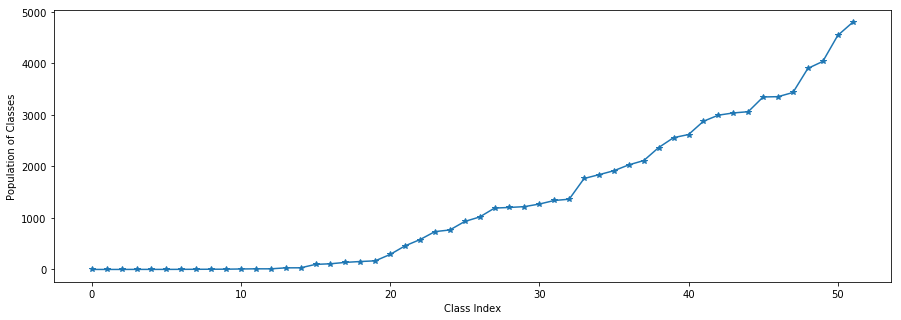

First 20 largest classes:
 [('DUE', 4796), ('DMS', 4542), ('DMI', 4038), ('EAR', 3903), ('SES', 3435), ('DMR', 3354), ('CHE', 3348), ('OCE', 3062), ('INT', 3038), ('IBN', 2995), ('BCS', 2877), ('DEB', 2619), ('MCB', 2559), ('CCR', 2367), ('ATM', 2114), ('CMS', 2031), ('DBI', 1917), ('PHY', 1840), ('ECS', 1766), ('OPP', 1364)]


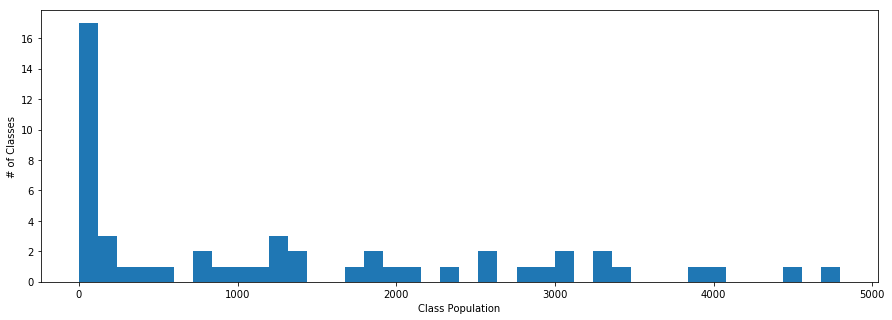

In [10]:
print('Class population in ascending order:\n',sorted(list(Counter(data['Tag'].tolist()).values())))
plt.figure(figsize=(15,5))
plt.plot(sorted(list(Counter(data['Tag'].tolist()).values())),'-*')
plt.ylabel('Population of Classes')
plt.xlabel('Class Index')
plt.show()

# Now we can also check the histogram but we choose bins to put close class populations together.
print('First 20 largest classes:\n',Counter(data['Tag'].tolist()).most_common(20))
plt.figure(figsize=(15,5))
plt.hist(list(Counter(data['Tag'].tolist()).values()),bins=40)
plt.ylabel('# of Classes')
plt.xlabel('Class Population')
plt.show()

In [11]:
tags = ['OCE','DMS','CHE']
data = data[data.Tag.isin(tags)]
data['Tokens'] = data.apply(lambda row: nltk.word_tokenize(row['Text']), axis=1)
print(len(data),'samples from',len(tags),'classes')
print(data.shape)

10952 samples from 3 classes
(10952, 3)


minimum text length is: 150
maximum text length is: 7941
mean and median text lengths are: 1560.47260774 1398.0


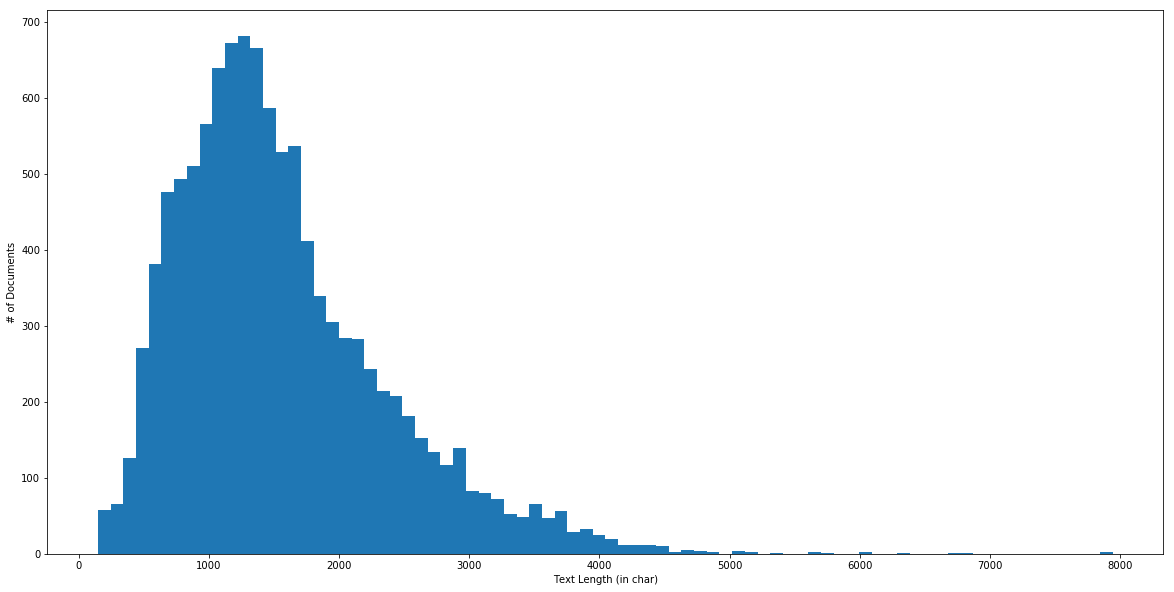

In [12]:
lens = [len(ii) for ii in data.Text]
print('minimum text length is:',np.min(lens))
print('maximum text length is:',np.max(lens))
print('mean and median text lengths are:',np.mean(lens),np.median(lens))
plt.figure(figsize=(20,10))
a=plt.hist(lens,bins=80)
plt.xlabel('Text Length (in char)')
plt.ylabel('# of Documents')
plt.show()


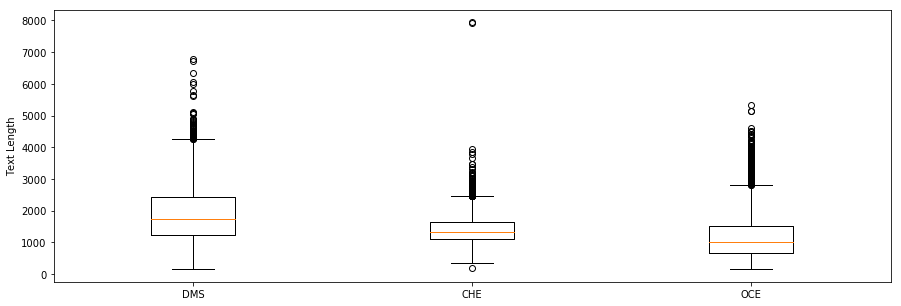

In [13]:
def len_of_tag(tag):
    return [len(ii) for ii in data[data.Tag == tag]['Text']]

tag_names = list(data.Tag.unique())

lengths = [len_of_tag(tag) for tag in tag_names]
plt.figure(figsize=(15,5))
plt.boxplot(lengths)
plt.ylabel('Text Length')
plt.xticks([ii for ii in range(1,len(tag_names)+1)], tag_names)
plt.show()


In [16]:
c_total = Counter()
for ind in data.index:
    c_total.update(Counter(data.loc[ind].Tokens))

In [17]:
print(c_total.most_common(50))

[('the', 167836), ('of', 136641), ('and', 95434), ('to', 62435), ('in', 62061), ('a', 44012), ('will', 32061), ('is', 29805), ('for', 27672), ('this', 24232), ('be', 22411), ('on', 18622), ('with', 16994), ('are', 16749), ('research', 16406), ('as', 15970), ('that', 15451), ('by', 14228), ('these', 11144), ('from', 10978), ('at', 9826), ('which', 9180), ('an', 9054), ('theory', 8496), ('chemistry', 8401), ('project', 8390), ('study', 8010), ('such', 7235), ('new', 7113), ('program', 6768), ('problems', 6428), ('have', 6299), ('systems', 6198), ('or', 6039), ('university', 5615), ('it', 5600), ('can', 5454), ('methods', 5424), ('has', 5391), ('work', 5239), ('one', 5159), ('data', 4954), ('their', 4953), ('used', 4789), ('models', 4756), ('s', 4669), ('mathematical', 4555), ('also', 4522), ('studies', 4475), ('important', 4266)]


In [20]:
c_unique = Counter()
for ind in data.index:
    c_unique.update(Counter(set(data.loc[ind].Tokens)))

In [21]:
for word in c_unique.most_common(50):
    print(word[0],'-->', word[1],'times = ',np.round(100*word[1]/len(data),2),'%')

of --> 10909 times =  99.61 %
the --> 10898 times =  99.51 %
and --> 10877 times =  99.32 %
to --> 10596 times =  96.75 %
in --> 10571 times =  96.52 %
a --> 9988 times =  91.2 %
this --> 9428 times =  86.08 %
for --> 9058 times =  82.71 %
is --> 9030 times =  82.45 %
will --> 8978 times =  81.98 %
be --> 8227 times =  75.12 %
on --> 7953 times =  72.62 %
with --> 7757 times =  70.83 %
by --> 7063 times =  64.49 %
as --> 6926 times =  63.24 %
are --> 6880 times =  62.82 %
research --> 6746 times =  61.6 %
from --> 6228 times =  56.87 %
that --> 6220 times =  56.79 %
these --> 5823 times =  53.17 %
at --> 5751 times =  52.51 %
an --> 5330 times =  48.67 %
which --> 4925 times =  44.97 %
project --> 4751 times =  43.38 %
study --> 4620 times =  42.18 %
program --> 4439 times =  40.53 %
university --> 4153 times =  37.92 %
such --> 4111 times =  37.54 %
new --> 4064 times =  37.11 %
have --> 3993 times =  36.46 %
chemistry --> 3584 times =  32.72 %
used --> 3518 times =  32.12 %
or --> 35

and what about the total number of words?

In [22]:
print(len(c_unique),'unique words i.e. the complete size of our vocab. This is the dimension of our BoW representation.')

print(np.sum(list(c_total.values())), 'words in total (with repeatations) i.e. sum of BoW matrix.')

40608 unique words i.e. the complete size of our vocab. This is the dimension of our BoW representation.
2503528 words in total (with repeatations) i.e. sum of BoW matrix.


In [23]:
tag_dict = {tag:Counter() for tag in data.Tag.unique()}
for ind in data.index:
    tag = data.loc[ind]['Tag']
    tag_dict[tag].update(Counter(set(data.loc[ind].Tokens)))

In [24]:
tag_specific_words = pd.DataFrame(columns=['OCE_Words','OCE_%','CHE_Words','CHE_%','DMS_Words','DMS_%'])
for tag in ['OCE','CHE', 'DMS']:
    len_tag = len(data[data['Tag']==tag])
    words = []
    percent = []
    for word in tag_dict[tag].most_common(20):
        words.append(word[0])
        percent.append(np.round(100*word[1]/len_tag,2))
    tag_specific_words[tag+'_Words'] = words
    tag_specific_words[tag+'_%'] = percent
display(tag_specific_words)

,OCE_Words,OCE_%,CHE_Words,CHE_%,DMS_Words,DMS_%
0,the,99.87,the,99.97,of,99.49
1,of,99.41,of,99.94,and,99.14
2,and,99.12,and,99.73,the,98.92
3,to,96.47,in,97.01,in,98.28
4,will,93.37,chemistry,96.74,to,96.96
5,in,93.37,to,96.71,a,93.77
6,a,88.18,will,92.03,is,89.56
7,this,82.53,program,91.97,for,88.51
8,be,74.33,a,90.47,this,86.35
9,for,73.42,this,88.98,on,80.23


In [25]:
for n_stop_words in [50,500,5000]:
    tag_specific_words = pd.DataFrame(columns=['OCE_Words','OCE_%','CHE_Words','CHE_%','DMS_Words','DMS_%'])
    print('Ignoring first',n_stop_words,'stop-words ##############')
    StopWords = [ii[0] for ii in c_unique.most_common(n_stop_words)]
    for tag in ['OCE','CHE', 'DMS']:
        len_tag = len(data[data['Tag']==tag])
        jj = 0
        words = []
        percent = []
        for word in tag_dict[tag].most_common(2*n_stop_words):
            if word[0] not in StopWords:
                words.append(word[0])
                percent.append(np.round(100*word[1]/len_tag,2))
                jj += 1
            if jj == 20:
                break
        tag_specific_words[tag+'_Words'] = words
        tag_specific_words[tag+'_%'] = percent
    display(tag_specific_words)
    print('\n\n')

Ignoring first 50 stop-words ##############


,OCE_Words,OCE_%,CHE_Words,CHE_%,DMS_Words,DMS_%
0,ocean,48.30,award,48.60,mathematical,49.34
1,data,37.66,department,46.12,applications,40.95
2,provide,28.67,organic,40.83,mathematics,38.99
3,marine,28.22,chemical,40.17,many,37.30
4,water,25.44,molecules,39.37,analysis,36.46
5,use,25.11,supported,38.80,two,34.54
6,during,22.89,professor,37.13,more,33.25
7,processes,22.66,reactions,34.53,equations,33.00
8,system,22.34,state,34.53,areas,30.74
9,support,21.91,molecular,34.23,not,30.63





Ignoring first 500 stop-words ##############


,OCE_Words,OCE_%,CHE_Words,CHE_%,DMS_Words,DMS_%
0,pacific,14.01,bioinorganic,13.89,equation,9.47
1,circulation,13.29,atoms,12.63,connections,9.40
2,atlantic,13.13,reactivity,12.51,mathematicians,9.38
3,operated,12.02,facilities,11.77,computation,9.25
4,variability,11.46,molecule,11.56,conjecture,8.98
5,oceanic,11.43,catalysts,11.44,existence,8.81
6,samples,11.04,resonance,11.41,random,8.78
7,oce,10.88,polymers,11.35,subject,8.65
8,vessel,10.81,containing,11.20,representation,8.48
9,coastal,10.74,catalysis,11.08,discrete,8.32





Ignoring first 5000 stop-words ##############


,OCE_Words,OCE_%,CHE_Words,CHE_%,DMS_Words,DMS_%
0,rov,0.91,heme,0.84,lecturer,0.62
1,sargasso,0.91,tin,0.81,grothendieck,0.62
2,downwelling,0.91,optoelectronic,0.81,walk,0.62
3,intertidal,0.88,amine,0.81,connes,0.59
4,irradiance,0.88,biomimetic,0.78,nilpotent,0.59
5,expedition,0.88,rhodium,0.78,lifting,0.59
6,multibeam,0.85,aldehydes,0.78,obstructions,0.59
7,borehole,0.85,bimetallic,0.78,markets,0.59
8,iceland,0.85,alkynes,0.78,bootstrap,0.59
9,diapycnal,0.85,antibiotics,0.78,estimator,0.59


In [27]:
import itertools
tags = data.Tag.unique().tolist()
vocabs = {}
for tag in tags:
    data_tmp = data[data.Tag==tag]
    tmp = [data_tmp.loc[ind].Tokens for ind in data_tmp.index]
    vocabs[tag] = set(list(itertools.chain.from_iterable(tmp)))
    print(len(data[data.Tag==tag]),'documents and',len(vocabs[tag]),'unique terms in class',tag)


4542 documents and 23720 unique terms in class DMS
3348 documents and 19114 unique terms in class CHE
3062 documents and 16855 unique terms in class OCE


In [35]:

word_scores = {}
for word in c_unique.keys():
    N_wc=len([tag for tag in tags if word in vocabs[tag]])
    word_scores[word] = (1./2.)*(3.-N_wc)/N_wc

import operator
sorted_word_scores = sorted(word_scores.items(), key=operator.itemgetter(1))
print('Some low-score examples:\n')
print(sorted_word_scores[0:100],'\n')
print('Some high-score examples:\n')
print(sorted_word_scores[-100::])

Counter(list(word_scores.values()))

(8214, 3)
(2738, 3)


10952

In [30]:
def qmean(a):
    return np.sqrt(np.mean([ii**2 for ii in a]))

features1 = []
tmp = {}
high_score_set = set([k for k in word_scores if word_scores[k]==1])
for tag in tags:
    print(tag,'-----------')
    lists = [list(set(data[data.Tag==tag].loc[ind].Tokens) & high_score_set) for ind in data[data.Tag==tag].index]
    tmp_words = list(itertools.chain.from_iterable(lists))
    tmp[tag] = Counter(tmp_words)
    features1 = features1 + [k[0] for k in tmp[tag].most_common(100)]

features2 = []
tmp = {}
high_score_set = set([k for k in word_scores if word_scores[k]==.25])
for tag in tags:
    print(tag,'-----------')
    lists = [list(set(data[data.Tag==tag].loc[ind].Tokens) & high_score_set) for ind in data[data.Tag==tag].index]
    tmp_words = list(itertools.chain.from_iterable(lists))
    tmp[tag] = Counter(tmp_words)
    features2 = features2 + [k[0] for k in tmp[tag].most_common(100)]

    
features3 = []
tmp = {}
high_score_set = set([k for k in word_scores if word_scores[k]==0.0])
for tag in tags:
    print(tag,'-----------')
    lists = [list(set(data[data.Tag==tag].loc[ind].Tokens) & high_score_set) for ind in data[data.Tag==tag].index]
    tmp_words = list(itertools.chain.from_iterable(lists))
    tmp[tag] = Counter(tmp_words)
    features3 = features3 + [k[0] for k in tmp[tag].most_common(20)]
    
    
    
features = features1 + features2 + features3
for tag in tags:
    cvr = [1 for ind in data[data.Tag==tag].index if len(list(set(data[data.Tag==tag].loc[ind].Tokens) & set(features)))>0]
    print('for tag',tag,100*len(cvr)/len(data[data.Tag==tag]),'% is covered')

DMS -----------
CHE -----------
OCE -----------
DMS -----------
CHE -----------
OCE -----------
DMS -----------
CHE -----------
OCE -----------
for tag DMS 100.0 % is covered
for tag CHE 100.0 % is covered
for tag OCE 100.0 % is covered


In [39]:
print(len(features), 'features in total')
print(len(set(features)))

660 features in total
617


In [42]:
train = data.sample(frac=.75)
test = data.loc[~data.index.isin(train.index)]


train_unique = Counter()
for ind in train.index:
    train_unique.update(Counter(set(train.loc[ind].Tokens)))

    
tags = data.Tag.unique().tolist()
train_vocabs = {}
for tag in tags:
    train_tmp = train[train.Tag==tag]
    tmp = [train_tmp.loc[ind].Tokens for ind in train_tmp.index]
    train_vocabs[tag] = set(list(itertools.chain.from_iterable(tmp)))
    print(len(train[train.Tag==tag]),'documents and',len(train_vocabs[tag]),'unique terms in class',tag)

    

train_word_scores = {}
for word in train_unique.keys():
    N_wc=len([tag for tag in tags if word in train_vocabs[tag]])
    train_word_scores[word] = (1./2.)*(3.-N_wc)/N_wc

train_sorted_word_scores = sorted(train_word_scores.items(), key=operator.itemgetter(1))
    
features1 = []
tmp = {}
high_score_set = set([k for k in train_word_scores if train_word_scores[k]==1])
for tag in tags:
    lists = [list(set(train[train.Tag==tag].loc[ind].Tokens) & high_score_set) for ind in train[train.Tag==tag].index]
    tmp_words = list(itertools.chain.from_iterable(lists))
    tmp[tag] = Counter(tmp_words)
    features1 = features1 + [k[0] for k in tmp[tag].most_common(150)]

features2 = []
tmp = {}
high_score_set = set([k for k in train_word_scores if train_word_scores[k]==.25])
for tag in tags:
    lists = [list(set(train[train.Tag==tag].loc[ind].Tokens) & high_score_set) for ind in train[train.Tag==tag].index]
    tmp_words = list(itertools.chain.from_iterable(lists))
    tmp[tag] = Counter(tmp_words)
    features2 = features2 + [k[0] for k in tmp[tag].most_common(150)]

    
features3 = []
tmp = {}
high_score_set = set([k for k in train_word_scores if train_word_scores[k]==0.0])
for tag in tags:
    lists = [list(set(train[train.Tag==tag].loc[ind].Tokens) & high_score_set) for ind in train[train.Tag==tag].index]
    tmp_words = list(itertools.chain.from_iterable(lists))
    tmp[tag] = Counter(tmp_words)
    features3 = features3 + [k[0] for k in tmp[tag].most_common(50)]


    
features = features1 + features2 + features3
print(len(set(features)), 'features in total')
for tag in tags:
    cvr = [1 for ind in data[data.Tag==tag].index if len(list(set(data[data.Tag==tag].loc[ind].Tokens) & set(features)))>0]
    print('for tag',tag,100*len(cvr)/len(data[data.Tag==tag]),'% is covered')    


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

features = list(set(features))
BoW = CountVectorizer(max_features = len(features))
TFIDF = TfidfVectorizer(max_features = len(features))
BoW_ours = CountVectorizer(vocabulary = features)

# Prepare data
train_x = train.Text.tolist()
test_x = test.Text.tolist()
train_y = train.Tag.tolist()
test_y = test.Tag.tolist()

# Extract features from train set
print('Feature Extraction Started!')
train_x_BoW = BoW.fit_transform(train_x)
train_x_TFIDF = TFIDF.fit_transform(train_x)
train_x_BoW_ours = BoW_ours.fit_transform(train_x)

# Project test set onto train features vector-space
print('Projecting Test Data!')
test_x_BoW = BoW.transform(test_x)
test_x_TFIDF = TFIDF.transform(test_x)
test_x_BoW_ours = BoW_ours.transform(test_x)

# Have a look at performance
for d in [(train_x_BoW,train_y,test_x_BoW,test_y,'Original BoW'),
          (train_x_TFIDF,train_y,test_x_TFIDF,test_y,'Original TF-IDF'),
          (train_x_BoW_ours,train_y,test_x_BoW_ours,test_y,'Our Inspection')]:
    clf = MultinomialNB()
    clf.fit(d[0], d[1])
    preds = clf.predict(d[2])
    print(d[4],'\n',classification_report(d[3], preds))
    print()


3411 documents and 20938 unique terms in class DMS
2511 documents and 16850 unique terms in class CHE
2292 documents and 15007 unique terms in class OCE
962 features in total
for tag DMS 100.0 % is covered
for tag CHE 100.0 % is covered
for tag OCE 100.0 % is covered
Feature Extraction Started!
Projecting Test Data!
Original BoW 
              precision    recall  f1-score   support

        CHE       0.98      0.99      0.98       837
        DMS       0.98      0.98      0.98      1131
        OCE       0.98      0.98      0.98       770

avg / total       0.98      0.98      0.98      2738


Original TF-IDF 
              precision    recall  f1-score   support

        CHE       0.98      0.99      0.99       837
        DMS       0.98      0.98      0.98      1131
        OCE       0.98      0.97      0.97       770

avg / total       0.98      0.98      0.98      2738


Our Inspection 
              precision    recall  f1-score   support

        CHE       0.97      0.99      0.